### Predictive Model to predict Survival of passengers on the Titanic based on the sinking of the 'Unsinkable' ship Titanic in 1912. Information about their ages, sexes, sibling counts, embarkment points and whether or not they survived is provided.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
%matplotlib inline
rcParams['figure.figsize'] = 14, 12
sb.set_style('whitegrid')

In [3]:
address = r"C:\Users\Raimi Anda\Data_Science_Scripts\Logistic Regression\titanic-training-data.csv"
titanic_training = pd.read_csv(address)
titanic_training.columns = ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
titanic_training.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Dataset Description

Survived - Survival (0 = No; 1 = Yes)<br>
Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)<br>
Name - Name<br>
Sex - Sex<br>
Age - Age<br>
SibSp - Number of Siblings/Spouses Aboard<br>
Parch - Number of Parents/Children Aboard<br>
Ticket - Ticket Number<br>
Fare - Passenger Fare (British pound)<br>
Cabin - Cabin<br>
Embarked - Port of Embarkation (C = Cherbourg, France; Q = Queenstown, UK; S = Southampton - Cobh, Ireland)

### Verify the assumptions of a Logistic Regression Model
* Free of missing values & outliers
* Predictant variable is binary (1 & 0)
* Predictors are independent of each other
* At least 50 observations

In [4]:
titanic_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Checking for missing Values

In [5]:
titanic_training.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Verifying Predictor is binary

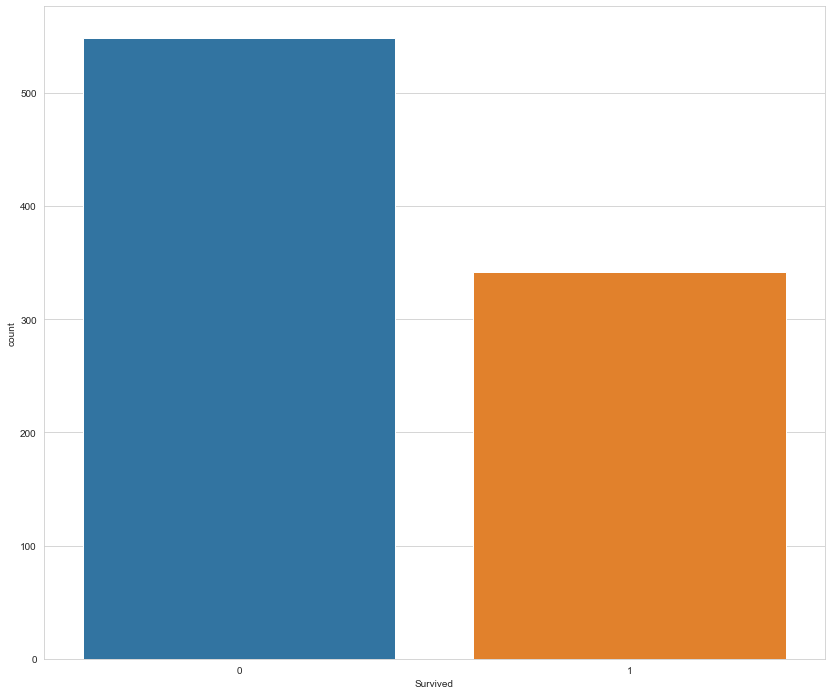

In [6]:
sb.countplot(x='Survived', data=titanic_training)

## Handling Missing data
Age is the most important variable having null values

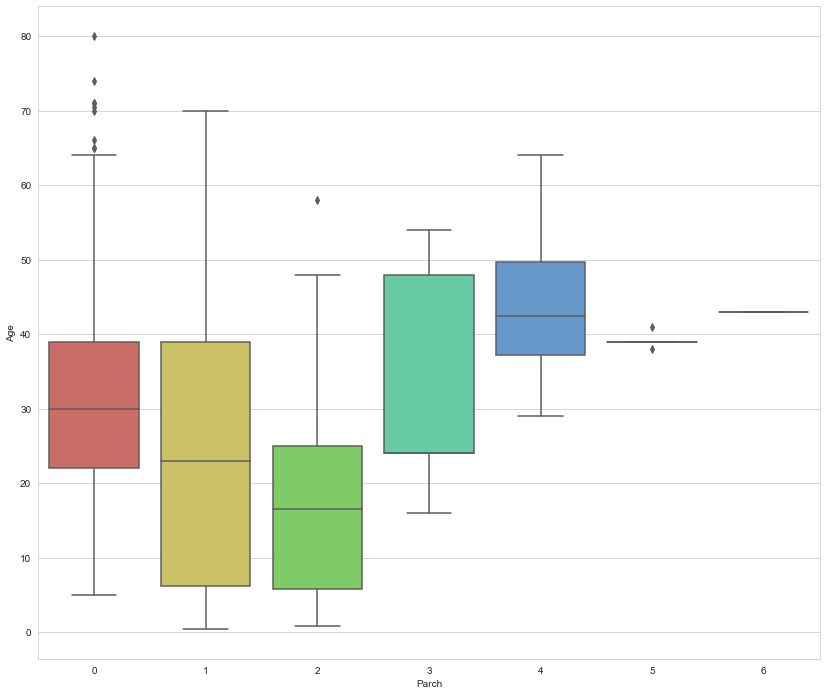

In [7]:
sb.boxplot(x='Parch', y='Age', data=titanic_training, palette='hls')

### The older a person is, themore likely they are to have 4 individuals on the ship who are either parents or children
This is good enough to make approximations of the age of a passenger based on the Parch.

In [8]:
#Infer using the mean age values depending on the Parch category
Parch_groups = titanic_training.groupby(titanic_training['Parch'])
Parch_groups.mean()

,PassengerId,Survived,Pclass,Age,SibSp,Fare
Parch,,,,,,
0,445.255162,0.343658,2.321534,32.178503,0.237463,25.586774
1,465.110169,0.550847,2.203390,24.422000,1.084746,46.778180
2,416.662500,0.500000,2.275000,17.216912,2.062500,64.337604
3,579.200000,0.600000,2.600000,33.200000,1.000000,25.951660
4,384.000000,0.000000,2.500000,44.500000,0.750000,84.968750
5,435.200000,0.200000,3.000000,39.200000,0.600000,32.550000
6,679.000000,0.000000,3.000000,43.000000,1.000000,46.900000


In [9]:
def age_approx(cols):
    Age = cols[0]
    Parch = cols[1]
    
    if pd.isnull(Age):
        if Parch == 0:
            return 32
        elif Parch == 1:
            return 24
        elif Parch == 2:
            return 17
        elif Parch == 3:
            return 33
        elif Parch == 4:
            return 45
        else:
            return 30
        
    else:
        return Age

In [10]:
titanic_training['Age']= titanic_training[['Age', 'Parch']].apply(age_approx, axis=1)
titanic_training.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Analyzing variables and dropping irrelevant ones
- Pclass - Does a passenger's class on the boat affect their survivability? - Probably
- Sex - Could a passenger's gender impact their survival rate? - Probably
- Age - Does a person's age impact their survival rate? - Probably
- SibSp - Does the number of relatives on the boat (that are siblings or a spouse) affect a person survivability? - Probably
- Parch - Does the number of relatives on the boat (that are children or parents) affect a person survivability? - Probably
- Fare - Does the fare a person paid effect his survivability? - Maybe, Position on the ship. Relevant
- Embarked - Does a person's point of embarkation matter? - Probably determines how the ship was filled.

- What about a person's name, ticket number, and passenger ID? They're all irrelavant for predicting survivability.
- The cabin variable is almost all missing values and it should be dropped.

In [11]:
titanic_data = titanic_training.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1)
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [12]:
titanic_data.dropna(inplace=True)
titanic_data.reset_index(inplace=True, drop=True)

print(titanic_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 8 columns):
Survived    889 non-null int64
Pclass      889 non-null int64
Sex         889 non-null object
Age         889 non-null float64
SibSp       889 non-null int64
Parch       889 non-null int64
Fare        889 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 55.7+ KB
None


### Converting categorical variables

In [13]:
titanic_data['Sex'][0:5]

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object

In [14]:
from sklearn.preprocessing import LabelEncoder as le
label_encoder = le()
titanic_data['Sex'] = label_encoder.fit_transform(titanic_data['Sex'])
titanic_data['Sex'][0:5]
# 1 = male / 0 = female

0    1
1    0
2    0
3    0
4    1
Name: Sex, dtype: int32

In [15]:
titanic_data['Embarked'] = titanic_data['Embarked'].astype(str)

In [16]:
titanic_data['Embarked'].head()

0    S
1    C
2    S
3    S
4    S
Name: Embarked, dtype: object

In [17]:
embarked_cat = titanic_data['Embarked']
embarked_encoded = label_encoder.fit_transform(embarked_cat)
embarked_encoded[0:100]

array([2, 0, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2,
       1, 2, 2, 2, 0, 2, 1, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0,
       1, 2, 1, 1, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2])

In [18]:
titanic_data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [19]:
from sklearn.preprocessing import OneHotEncoder
binary_encoder = OneHotEncoder(categories='auto')
embarked_1hot = binary_encoder.fit_transform(embarked_encoded.reshape(-1,1))
embarked_1hot_mat = embarked_1hot.toarray()
embarked_df = pd.DataFrame(embarked_1hot_mat, columns = ['C', 'Q', 'S'])
embarked_df.head()

,C,Q,S
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0


In [20]:
titanic_final = pd.concat([titanic_data, embarked_df], axis=1, verify_integrity=True)
titanic_final[0:5]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,C,Q,S
0,0,3,1,22.0,1,0,7.2500,S,0.0,0.0,1.0
1,1,1,0,38.0,1,0,71.2833,C,1.0,0.0,0.0
2,1,3,0,26.0,0,0,7.9250,S,0.0,0.0,1.0
3,1,1,0,35.0,1,0,53.1000,S,0.0,0.0,1.0
4,0,3,1,35.0,0,0,8.0500,S,0.0,0.0,1.0


In [21]:
titanic_final.drop(['Embarked'], axis=1, inplace=True)
titanic_final.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
0,0,3,1,22.0,1,0,7.2500,0.0,0.0,1.0
1,1,1,0,38.0,1,0,71.2833,1.0,0.0,0.0
2,1,3,0,26.0,0,0,7.9250,0.0,0.0,1.0
3,1,1,0,35.0,1,0,53.1000,0.0,0.0,1.0
4,0,3,1,35.0,0,0,8.0500,0.0,0.0,1.0


In [22]:
titanic_final[['Survived','Pclass','Sex','SibSp','Parch']] = titanic_final[['Survived','Pclass','Sex','SibSp','Parch']].astype(float)

In [23]:
titanic_final.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
0,0.0,3.0,1.0,22.0,1.0,0.0,7.2500,0.0,0.0,1.0
1,1.0,1.0,0.0,38.0,1.0,0.0,71.2833,1.0,0.0,0.0
2,1.0,3.0,0.0,26.0,0.0,0.0,7.9250,0.0,0.0,1.0
3,1.0,1.0,0.0,35.0,1.0,0.0,53.1000,0.0,0.0,1.0
4,0.0,3.0,1.0,35.0,0.0,0.0,8.0500,0.0,0.0,1.0


In [24]:
titanic_final['Parch'].value_counts()

0.0    676
1.0    118
2.0     80
3.0      5
5.0      5
4.0      4
6.0      1
Name: Parch, dtype: int64

In [25]:
print(titanic_final.corr())

          Survived    Pclass       Sex       Age     SibSp     Parch  \
Survived  1.000000 -0.335549 -0.541585 -0.072126 -0.034040  0.083151   
Pclass   -0.335549  1.000000  0.127741 -0.328299  0.081656  0.016824   
Sex      -0.541585  0.127741  1.000000  0.103011 -0.116348 -0.247508   
Age      -0.072126 -0.328299  0.103011  1.000000 -0.295432 -0.220454   
SibSp    -0.034040  0.081656 -0.116348 -0.295432  1.000000  0.414542   
Parch     0.083151  0.016824 -0.247508 -0.220454  0.414542  1.000000   
Fare      0.255290 -0.548193 -0.179958  0.076341  0.160887  0.217532   
C         0.169966 -0.245733 -0.084520  0.034083 -0.060074 -0.011588   
Q         0.004536  0.220558 -0.075217  0.012844 -0.026692 -0.081585   
S        -0.151777  0.076466  0.121405 -0.037949  0.069438  0.061512   

              Fare         C         Q         S  
Survived  0.255290  0.169966  0.004536 -0.151777  
Pclass   -0.548193 -0.245733  0.220558  0.076466  
Sex      -0.179958 -0.084520 -0.075217  0.121405  
Age

(10, 0)

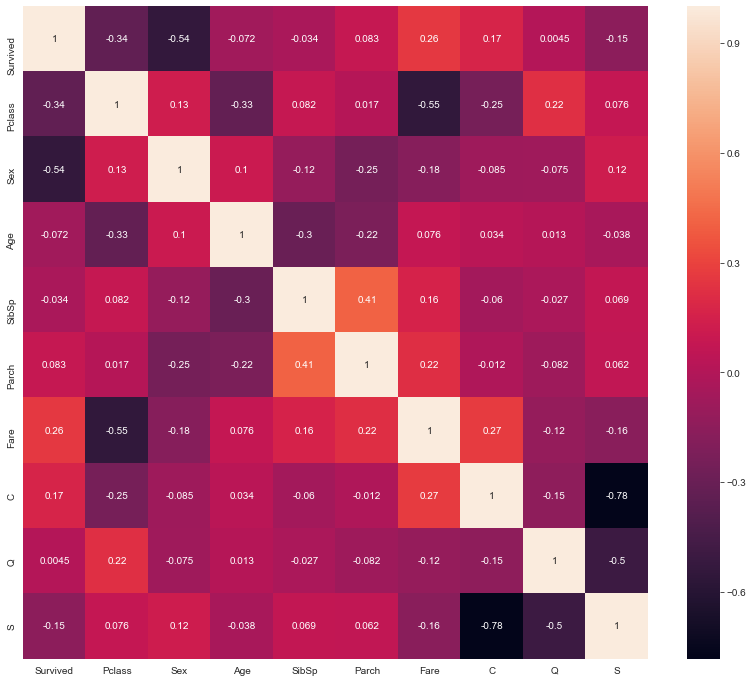

In [26]:
ax = sb.heatmap(titanic_final.corr(), annot=True)
ax.set_ylim(10,0)

In [27]:
titanic_final.drop(['Fare','Pclass'], axis=1, inplace=True)
titanic_final.head()

,Survived,Sex,Age,SibSp,Parch,C,Q,S
0,0.0,1.0,22.0,1.0,0.0,0.0,0.0,1.0
1,1.0,0.0,38.0,1.0,0.0,1.0,0.0,0.0
2,1.0,0.0,26.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,35.0,1.0,0.0,0.0,0.0,1.0
4,0.0,1.0,35.0,0.0,0.0,0.0,0.0,1.0


In [28]:
x = titanic_final.drop('Survived', axis=1)
y = titanic_final['Survived']
x = x.values
y= y.values

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=200)

In [31]:
print(x_train.shape)
print(y_train.shape)

(711, 7)
(711,)


In [32]:
LogReg = LogisticRegression(solver='liblinear')
LogReg.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
y_pred = LogReg.predict(x_test)

In [34]:
y_pred[0:10]

array([0., 1., 1., 0., 0., 0., 1., 0., 0., 0.])

In [35]:
y_test[0:10]

array([0., 1., 0., 0., 0., 0., 1., 1., 0., 0.])

In [36]:
var_prob = LogReg.predict_proba(x_test)

In [37]:
var_prob

array([[0.80111886, 0.19888114],
       [0.14079202, 0.85920798],
       [0.38107121, 0.61892879],
       [0.68601571, 0.31398429],
       [0.82470092, 0.17529908],
       [0.69759814, 0.30240186],
       [0.17862822, 0.82137178],
       [0.73307626, 0.26692374],
       [0.79104102, 0.20895898],
       [0.78586305, 0.21413695],
       [0.68434154, 0.31565846],
       [0.21523872, 0.78476128],
       [0.40808365, 0.59191635],
       [0.20005248, 0.79994752],
       [0.2854518 , 0.7145482 ],
       [0.26050244, 0.73949756],
       [0.25032363, 0.74967637],
       [0.87477948, 0.12522052],
       [0.16701468, 0.83298532],
       [0.80111886, 0.19888114],
       [0.80111886, 0.19888114],
       [0.82357605, 0.17642395],
       [0.17684315, 0.82315685],
       [0.25163215, 0.74836785],
       [0.80480261, 0.19519739],
       [0.78975522, 0.21024478],
       [0.80111886, 0.19888114],
       [0.82966074, 0.17033926],
       [0.32026822, 0.67973178],
       [0.39493897, 0.60506103],
       [0.

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.88      0.85       109
         1.0       0.79      0.71      0.75        69

    accuracy                           0.81       178
   macro avg       0.81      0.80      0.80       178
weighted avg       0.81      0.81      0.81       178



In [39]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[96, 13],
       [20, 49]], dtype=int64)

In [40]:
print(cm)

[[96 13]
 [20 49]]


In [41]:
print(LogReg.score(x_train, y_train))

0.7862165963431786


In [42]:
print(LogReg.score(x_test, y_test))

0.8146067415730337


In [43]:
from sklearn.metrics import f1_score
print(f1_score(y_test, y_pred))

0.7480916030534351


In [44]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.8146067415730337


### Make a test prediction

In [45]:
titanic_final[800:801]

,Survived,Sex,Age,SibSp,Parch,C,Q,S
800,1.0,0.0,31.0,1.0,1.0,0.0,0.0,1.0


In [46]:
test_passenger = np.array([1, 32, 0, 0, 0, 0, 1]).reshape(1,-1)

print(LogReg.predict(test_passenger))
print(LogReg.predict_proba(test_passenger))

[0.]
[[0.80111886 0.19888114]]
